In [1]:
import copy
import time, importlib
import h5py
import pylab as pl, numpy as np, glob, pdb
from numpy import log10 as log
from astropy import units as un, constants as cons
from astropy.cosmology import Planck15 as cosmo
import scipy, scipy.ndimage
import coolingFunction

# Parameters

In [2]:
group='metal_diffusion'; groupshort = 'md'
galaxyname='m12i'
res=7100

In [3]:
mu = 0.62
X = 0.7
gamma = 5/3

In [4]:
figDir = '../figures/'
tables_dir = '/work/03057/zhafen/CoolingTables/'

In [5]:
# so there are at least 20 snapshots after accretion, not including last 10 snapshots with small
minInd = 30
# t_1e5 bins in Gyr
t1e5_width = 0.5

# Load Data

In [6]:
halo_centers_all_sims = h5py.File('../data/halo_centers.hdf5')
fn_template='/scratch/03057/zhafen/linefinder_data/%s/%s_res%d/data/ptracks_%s_%s_hothaloacc.hdf5'%(group,galaxyname,res,galaxyname,groupshort)
fn=glob.glob(fn_template)[0]
f=h5py.File(fn)
print(f.keys())
halo_centers = halo_centers_all_sims['%s_%s'%(galaxyname,groupshort)]

KeysView(<HDF5 file "ptracks_m12i_md_hothaloacc.hdf5" (mode r+)>)


# Analyze

### Find $t_{10^5 K}$

In [7]:
# Find indices where temperature is greature than 1e5 K
q = (log(f['T'])>5).nonzero()
print(34346 in q[0])
inds = np.concatenate([
    [q[1][0]],
    q[1][1:][q[0][1:]!=q[0][:-1]]
])
inds_j = np.concatenate([inds[:34346],[0],inds[34346:]])
print(len(inds))
minInd = 30 # so there are at least 20 snapshots after accretion, not including last 10 snapshots with small dt

False
45845


/home1/03057/zhafen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [8]:
# Identify indices where temperature is first above 1e5 K
# This method is equivalent to Jonathan's commented out method above, but without needing to manually handle edge cases,
# at the cost of being slightly slower

logT = log( f['T'] )
inds = []
for logT_arr in logT:

    ind_ = 0
    for i in range( logT_arr.size ):
        if logT_arr[i] > 5.:
            ind_ = i
            break

    inds.append( ind_ )

inds = np.array( inds )

(-50, 100)

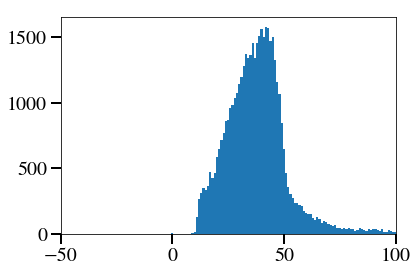

In [9]:
pl.hist(inds,bins=np.arange(-30.5,601))
pl.xlim(-50,100)

In [10]:
# Get t_1e5K
age = cosmo.age(f['redshift'][...]).to('Gyr').value
t1e5 = age[inds]

(10, 13.79761666410924)

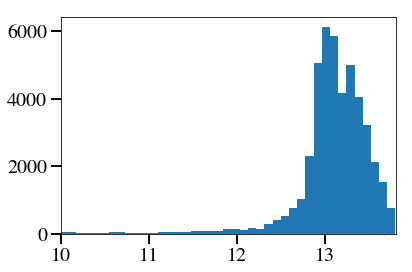

In [11]:
pl.hist(t1e5,bins=128)
pl.xlim(10,t1e5.max())

### Center on $t_{10^5 K}$

In [12]:
def roll_by_inds(arr, inds):
    rows, cols = np.ogrid[:arr.shape[0],:arr.shape[1]]
    cols = (cols + inds[:,np.newaxis])%arr.shape[1]
    return arr[rows,cols]

In [13]:
nH = roll_by_inds(f['Den'][:,:],inds)[inds>minInd]
mass = roll_by_inds(f['M'][:,:],inds)[inds>minInd]
coords = roll_by_inds(f['P'][:,:],inds)[inds>minInd]
T = roll_by_inds(f['T'][:,:],inds)[inds>minInd]
vs = roll_by_inds(f['V'][:,:],inds)[inds>minInd]
Z2Zsun = roll_by_inds(f['Z'][:,:],inds)[inds>minInd]
t1e5 = t1e5[inds>minInd]

In [14]:
t_unrolled = cosmo.age(f['redshift'][...]).to('s').value.repeat(f['Den'][...].shape[0]).reshape(f['Den'][...].T.shape).T
dt_unrolled = np.gradient(t_unrolled,axis=1)
dt0 = np.median(dt_unrolled[0,:100]) 
t = roll_by_inds(t_unrolled[:,:],inds)[inds>minInd]

In [15]:
dnHdt_unrolled = np.gradient(f['Den'][...],axis=1) / dt0
dnHdt = roll_by_inds(dnHdt_unrolled[:,:],inds)[inds>minInd]

### Calculate Cooling and Compression

In [16]:
R=(((coords - halo_centers[:,:].T)**2.).sum(axis=2))**0.5
K= T/nH**(2/3.) * (cons.k_B*un.K*un.cm**2).to('keV*cm**2')
P = (mu * X)**-1 * nH * cons.k_B.to('erg/K').value * T
rho = nH*cons.m_p.to('g').value / X
V = np.float64(mass) / rho * un.Msun.to('g')

In [17]:
LAMBDA = coolingFunction.LambdaFunc(0, tables_dir, 0.2485)(T,nH,Z2Zsun) #using z=0 is an approximation
rad_per_unit_volume = nH**2*LAMBDA 
rad_per_unit_mass   = rad_per_unit_volume / rho 
rad = rad_per_unit_mass * mass * un.Msun.to('g')

In [18]:
compress_per_unit_volume = P*dnHdt / nH 
compress_per_unit_mass = compress_per_unit_volume  / rho 

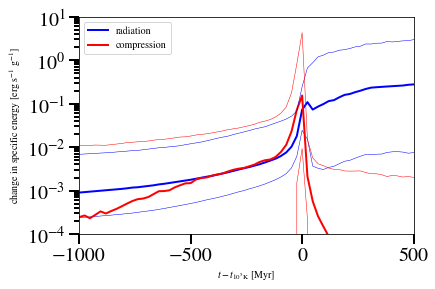

In [19]:
inds2 = np.arange(-50,100)
pl.figure()
ax=pl.subplot(111)
for ip,p in enumerate((16,50,84)):
    pl.plot(inds2*dt0/un.Myr.to('s'), np.nanpercentile(rad_per_unit_mass,p,axis=0)[inds2],
            c='b',lw=(0.5,2)[ip==1],label=('_',r'radiation')[ip==1])
    pl.plot(inds2*dt0/un.Myr.to('s'), np.nanpercentile(compress_per_unit_mass,p,axis=0)[inds2],
            c='r',lw=(0.5,2)[ip==1],
           label=('_',r'compression')[ip==1])
ax.set_yscale('log')
pl.xlim(-1000,500)
pl.ylim(1e-4,10) 
pl.ylabel(r'change in specific energy [${\rm erg}\ {\rm s}^{-1}\ {\rm g}^{-1}$]')
pl.xlabel(r'$t - t_{10^5{\rm K}}\ [{\rm Myr}]$')
pl.legend()
pl.savefig(figDir+'rad_vs_compress.png')

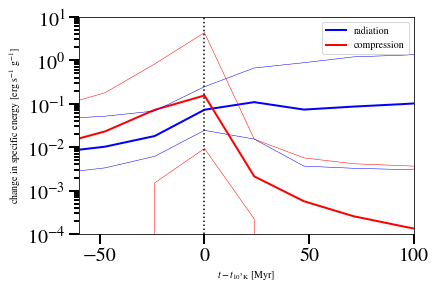

In [20]:
inds2 = np.arange(-50,100)
pl.figure()
ax=pl.subplot(111)
for ip,p in enumerate((16,50,84)):
    pl.plot(inds2*dt0/un.Myr.to('s'), np.nanpercentile(rad_per_unit_mass,p,axis=0)[inds2],
            c='b',lw=(0.5,2)[ip==1],label=('_',r'radiation')[ip==1])
    pl.plot(inds2*dt0/un.Myr.to('s'), np.nanpercentile(compress_per_unit_mass,p,axis=0)[inds2],
            c='r',lw=(0.5,2)[ip==1],
           label=('_',r'compression')[ip==1])
ax.set_yscale('log')
pl.xlim(-60,100)
pl.ylim(1e-4,10) 
pl.ylabel(r'change in specific energy [${\rm erg}\ {\rm s}^{-1}\ {\rm g}^{-1}$]')
pl.xlabel(r'$t - t_{10^5{\rm K}}\ [{\rm Myr}]$')
pl.legend()
pl.axvline(0,c='k',ls=':')
pl.savefig(figDir+'rad_vs_compress_zoom.png')

### Bin into bins of $t_{10^5 K}$ and sum heating and cooling

In [21]:
t1e5_width = 0.1

In [22]:
# Bins. Note that we offset by the last snapshot to avoid the most obvious edge cases
t1e5_bins = np.arange( age.max() + 0.5*(age[0] - age[1]), 11., -t1e5_width )

In [23]:
time = inds2*dt0/un.Myr.to('s')

In [24]:
# This is essential. If not removing outliers we get very weird results when calculating the mean.
def remove_outliers( a, q=99 ):
    outlier = np.nanpercentile( np.abs( a ), q )
    result = copy.copy( a )
    result[np.abs(a)>outlier] = outlier
    
    return result

In [25]:
binned_rad_per_unit_mass = []
binned_compress_per_unit_mass = []
mean_rad_per_unit_mass = []
mean_compress_per_unit_mass = []
for i, start in enumerate( t1e5_bins[:-1] ):
    
    end = t1e5_bins[i+1]
    in_bin = ( t1e5 < start ) & ( t1e5 > end )
    
    binned_rad_per_unit_mass.append( rad_per_unit_mass[in_bin] )
    binned_compress_per_unit_mass.append( compress_per_unit_mass[in_bin] )
    
    # Don't try to sum t1e5 bins with too few particles
    if in_bin.sum() < 10:
        mean_rad_per_unit_mass.append( np.full( (600,), np.nan ) )
        mean_compress_per_unit_mass.append( np.full( (600,), np.nan ) )
        continue
        
    # Avoid edge cases affecting the results
    rad = remove_outliers( rad_per_unit_mass[in_bin] )
    compress = remove_outliers( compress_per_unit_mass[in_bin] )
        
    mean_rad_per_unit_mass.append( np.nanmean( rad, axis=0 ) )
    mean_compress_per_unit_mass.append( np.nanmean( compress, axis=0 ) )

/home1/03057/zhafen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


In [26]:
n_bin = np.array([ _.shape[0] for _ in binned_rad_per_unit_mass ])

/home1/03057/zhafen/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1019: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


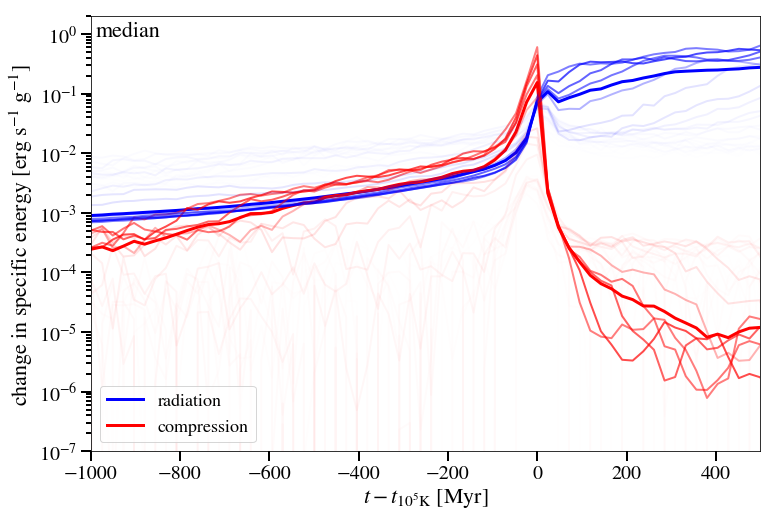

In [27]:
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

# Total median
ax.plot(
    time,
    np.nanmedian( rad_per_unit_mass, axis=0 )[inds2],
    color = 'b',
    linewidth = 3,
    label = 'radiation',
)
ax.plot(
    time,
    np.nanmedian( compress_per_unit_mass, axis=0 )[inds2],
    color = 'r',
    linewidth = 3,
    label = 'compression',
)

# In bins
for i, rad in enumerate( binned_rad_per_unit_mass ):
    ax.plot(
        time,
        np.nanmedian( rad, axis=0 )[inds2],
        color = 'b',
        alpha = n_bin[i]/n_bin.max() * 0.7,
        linewidth = 2,
    )
    ax.plot(
        time,
        np.nanmedian( binned_compress_per_unit_mass[i], axis=0 )[inds2],
        color = 'r',
        alpha = n_bin[i]/n_bin.max() * 0.7,
        linewidth = 2,
    )
    
ax.annotate(
    s = 'median',
    xy = ( 0, 1 ),
    xytext = ( 5, -5 ),
    xycoords = 'axes fraction',
    textcoords = 'offset points',
    fontsize = 22,
    va = 'top',
    ha = 'left',
)

ax.set_yscale( 'log' )
ax.set_xlim( -1000, 500 )
ax.set_ylim( 1e-7, 2 )
ax.legend( prop={'size': 18}, loc='lower left', )

ax.set_ylabel( r'change in specific energy [${\rm erg}\ {\rm s}^{-1}\ {\rm g}^{-1}$]', fontsize=22 )
ax.set_xlabel( r'$t - t_{10^5{\rm K}}\ [{\rm Myr}]$', fontsize=22 )

pl.savefig( figDir+'rad_vs_compress_median.pdf' )

In [28]:
np.nanmean( remove_outliers( rad_per_unit_mass ), axis=0 )[inds2]

/home1/03057/zhafen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


array([0.20895398, 0.24012333, 0.28921498, 0.3479383 , 0.41493605,
       0.48449799, 0.55888525, 0.65478592, 0.75809876, 0.84528887,
       0.9604686 , 1.05836204, 1.18623356, 1.27816517, 1.39948353,
       1.52958368, 1.64016611, 1.77314935, 1.93113112, 2.02473549,
       1.87320458, 1.73979189, 1.64988112, 1.56909567, 1.47145435,
       1.41316655, 1.35712947, 1.31258056, 1.28159099, 1.24799068,
       1.21902661, 1.21262467, 1.190707  , 1.17849772, 1.1963165 ,
       1.15144919, 1.14340636, 1.12410695, 1.12388614, 1.06120473,
       1.03179297, 0.98750414, 0.95083428, 0.93318123, 0.88422469,
       0.86249667, 0.80747616, 0.74275611, 0.6013675 , 0.43928938,
       0.18318617, 0.08027659, 0.07003135, 0.06424341, 0.05952851,
       0.05775872, 0.05573165, 0.05428061, 0.05444878, 0.05267122,
       0.05036219, 0.05091158, 0.05181039, 0.05216321, 0.04658399,
       0.04985778, 0.05248558, 0.05034321, 0.05570729, 0.05362609,
       0.05189473, 0.05142475, 0.05244922, 0.05500054, 0.05377

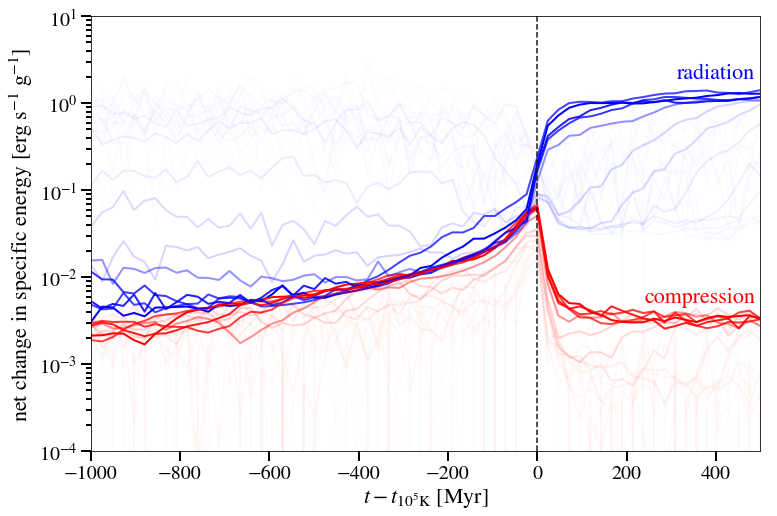

In [36]:
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

for i, rad in enumerate( mean_rad_per_unit_mass ):
    
#     # Don't look at edge cases from early on
#     if t1e5_bins[i] < 12:
#         continue
    
    ax.plot(
        time,
        rad[inds2],
        color = 'b',
        alpha = n_bin[i]/n_bin.max(),
        linewidth = 2,
    )
    ax.plot(
        time,
        mean_compress_per_unit_mass[i][inds2],
        color = 'r',
        alpha = n_bin[i]/n_bin.max(),
        linewidth = 2,
    )

# ax.plot(
#     time,
#     np.nanmean( rad_per_unit_mass, axis=0 )[inds2],
#     color = 'b',
#     linewidth = 3,
#     linestyle = '--',
# )
# ax.plot(
#     time,
#     np.nanmean( compress_per_unit_mass, axis=0 )[inds2],
#     color = 'r',
#     linewidth = 3,
#     linestyle = '--',
# )
# Total mean
# ax.plot(
#     time,
#     np.nanmean( remove_outliers( rad_per_unit_mass ), axis=0 )[inds2],
#     color = 'b',
#     linewidth = 3,
#     label = 'radiation',
# )
# ax.plot(
#     time,
#     np.nanmean( remove_outliers( compress_per_unit_mass ), axis=0 )[inds2],
#     color = 'r',
#     linewidth = 3,
#     label = 'compression',
# )

ax.annotate(
    s = 'radiation',
    xy = ( 1, 1.5 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, 5 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'right',
    fontsize = 22,
    color = 'b',
)
ax.annotate(
    s = 'compression',
    xy = ( 1, 4e-3 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    xytext = ( -5, 5 ),
    textcoords = 'offset points',
    va = 'bottom',
    ha = 'right',
    fontsize = 22,
    color = 'r',
)

ax.axvline(
    0.,
    linewidth = 1.5,
    linestyle = '--',
    color = '0.1',
)
    
# ax.annotate(
#     s = 'mean',
#     xy = ( 0, 1 ),
#     xytext = ( 5, -5 ),
#     xycoords = 'axes fraction',
#     textcoords = 'offset points',
#     fontsize = 22,
#     va = 'top',
#     ha = 'left',
# )

ax.set_yscale( 'log' )
ax.set_xlim( -1000, 500 )
ax.set_ylim( 1e-4, 10 )
# ax.legend( prop={'size': 18}, loc='lower left', )

ax.set_ylabel( r'net change in specific energy [${\rm erg}\ {\rm s}^{-1}\ {\rm g}^{-1}$]', fontsize=22 )
ax.set_xlabel( r'$t - t_{10^5{\rm K}}\ [{\rm Myr}]$', fontsize=22 )

pl.savefig( figDir+'rad_vs_compress.pdf' )

Things of note:
* I removed outliers. (Dashed is what happens when I don't yeet contributions from the 99th percentile of absolute specific energy.)
* Alpha scales with n_bin

In [30]:
def e_per_m_hist( ax, e_per_m ):
    bins = np.logspace( -5, np.log10( np.nanmax( np.abs( e_per_m ) ) ), 32 )

    ax.hist(
        np.abs( e_per_m ),
        bins = bins,
        histtype = 'step',
        linewidth = 3,
        color = 'k',
    )
    ax.hist(
        np.abs( e_per_m[e_per_m<0] ),
        bins = bins,
        histtype = 'step',
        linewidth = 3,
        color = 'k',
        linestyle = ':',
        label = 'negative',
    )
    ax.hist(
        np.abs( e_per_m[e_per_m>0] ),
        bins = bins,
        histtype = 'step',
        linewidth = 3,
        color = 'k',
        linestyle = '--',
        label = 'positive',
    )

    ax.axvline(
        np.nanmedian( e_per_m ),
        linewidth = 3,
    )
    ax.axvline(
        np.nanmean( remove_outliers( e_per_m ) ),
        linewidth = 3,
        linestyle = '--',
    )
    ax.annotate(
        s = 'median = {:.2g}\nmean={:.2g}'.format( np.nanmedian( e_per_m ), np.nanmean( e_per_m ) ),
        xy = ( 0, 1 ),
        xytext = ( 5, -5 ),
        xycoords = 'axes fraction',
        textcoords = 'offset points',
        fontsize = 18,
        va = 'top',
        ha = 'left',
    )

    ax.set_xscale( 'log' )

    ax.legend( prop={'size': 18} )


/home1/03057/zhafen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':
/home1/03057/zhafen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/home1/03057/zhafen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


Text(0.5, 0, 'Magnitude of Change in Radiation Specific Energy')

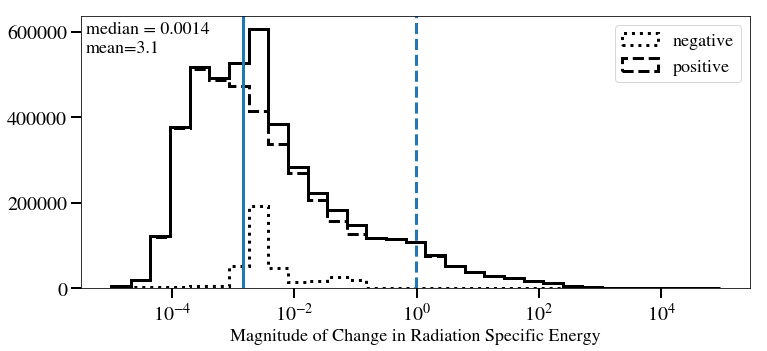

In [31]:
fig = plt.figure( figsize=(12,5), facecolor='w' )
ax = plt.gca()

e_per_m_hist( ax, rad_per_unit_mass[:,inds2].flatten(),)

ax.set_xlabel( 'Magnitude of Change in Radiation Specific Energy', fontsize=18 )

/home1/03057/zhafen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':
/home1/03057/zhafen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/home1/03057/zhafen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


Text(0.5, 0, 'Magnitude of Change in Compression Specific Energy')

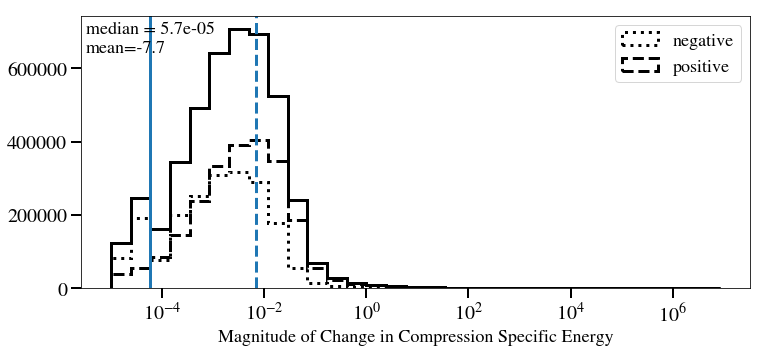

In [32]:
fig = plt.figure( figsize=(12,5), facecolor='w' )
ax = plt.gca()

e_per_m_hist( ax, compress_per_unit_mass[:,inds2].flatten(),)

ax.set_xlabel( 'Magnitude of Change in Compression Specific Energy', fontsize=18 )